In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
# Navegar hasta la raíz del proyecto 
WORKSPACE = os.path.abspath(os.path.join(os.getcwd(), '../../'))

# Definir la ruta de la carpeta de datos
DATA_FOLDER = os.path.join(WORKSPACE, 'data')

print("Workspace:", WORKSPACE)
print("Data folder:", DATA_FOLDER)

Workspace: /home/jovyan/work/mlds6
Data folder: /home/jovyan/work/mlds6/data


In [151]:
df = pd.read_csv(os.path.join(DATA_FOLDER, 'data_modelo.csv'))
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.set_index('Fecha', inplace=True)

In [152]:
# Columnas a escalar
columns = df.columns.difference(['Fecha', 'CodigoEstacion'])

# Escalar las columnas especificadas por grupo
scaled_df = df
for column in columns:
    scaled_df[column] = scaled_df.groupby('CodigoEstacion')[column].transform(lambda x: x / x.max())

In [153]:
station_codes = df['CodigoEstacion'].unique().reshape(-1, 1)  

# Aplicar OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = encoder.fit_transform(station_codes)

# Crear un diccionario para almacenar el número de la estación y su representación onehotencoder
station_dict = {}
for i, station in enumerate(station_codes):
    station_dict[station[0]] = onehot_encoded[i]

# Guardar station_dict
with open(DATA_FOLDER+'/station_dict.pkl', 'wb') as f:
    pickle.dump(station_dict, f)

In [157]:
# Definir la función para dividir los datos por cada 'CodigoEstacion'
def split_by_station(df):
    X_train_list = []
    y_train_list = []
    X_val_list = []
    y_val_list = []
    X_test_list = []
    y_test_list = []
    
    # Agrupar por 'CodigoEstacion'
    for estacion in df['CodigoEstacion'].unique():
        # Filtrar los datos para cada estación
        df_station = df[df['CodigoEstacion'] == estacion]
        
        # Calcular el tamaño de cada conjunto (80%, 10%, 10%)
        n = len(df_station)
        train_size = int(0.8 * n)
        val_size = int(0.1 * n)
        
        # Dividir los datos en entrenamiento, validación y prueba
        df_train = df_station[:train_size]
        df_val = df_station[train_size:train_size + val_size]
        df_test = df_station[train_size + val_size:]
        
        # Separar las características (X) y el objetivo (y) de cada conjunto
        X_train_list.append(df_train.drop(columns=['PTPM_CON_shifted']))
        y_train_list.append(df_train['PTPM_CON_shifted'])
        
        X_val_list.append(df_val.drop(columns=['PTPM_CON_shifted']))
        y_val_list.append(df_val['PTPM_CON_shifted'])
        
        X_test_list.append(df_test.drop(columns=['PTPM_CON_shifted']))
        y_test_list.append(df_test['PTPM_CON_shifted'])
    
    # Concatenar los resultados en DataFrames finales
    X_train = pd.concat(X_train_list)
    y_train = pd.concat(y_train_list)
    X_val = pd.concat(X_val_list)
    y_val = pd.concat(y_val_list)
    X_test = pd.concat(X_test_list)
    y_test = pd.concat(y_test_list)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Llamamos a la función para dividir los datos
X_train, y_train, X_val, y_val, X_test, y_test = split_by_station(scaled_df)

In [158]:
# Reemplazar el valor de 'CodigoEstacion' por su respectivo encoder en station_dict
X_train['CodigoEstacion'] = X_train['CodigoEstacion'].map(station_dict)
X_val['CodigoEstacion'] = X_val['CodigoEstacion'].map(station_dict)
X_test['CodigoEstacion'] = X_test['CodigoEstacion'].map(station_dict)

In [159]:
def flatten_features(df, array_column='CodigoEstacion'):
    # Extraer y expandir la columna de arrays especificada
    array_expanded = np.vstack(df[array_column])
    # Extraer las demás columnas (excluyendo la columna de arrays)
    other_cols = np.array(df.drop(columns=[array_column]))
    # Concatenar la columna expandida con las demás columnas
    result = np.hstack([array_expanded, other_cols])
    return result

# Aplicamos la función para convertir los DataFrames X_train, X_val, X_test
X_train = flatten_features(X_train, array_column='CodigoEstacion')
X_val = flatten_features(X_val, array_column='CodigoEstacion')
X_test = flatten_features(X_test, array_column='CodigoEstacion')

# Convertimos y_train, y_val, y_test directamente (no necesitan transformación especial)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array (y_test)

# Verificar las dimensiones
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


X_train shape: (244930, 49)
X_val shape: (30599, 49)
X_test shape: (30653, 49)
y_train shape: (244930,)
y_val shape: (30599,)
y_test shape: (30653,)


In [160]:
def build_model(hp):
    model = tf.keras.Sequential()

    # Capa de entrada
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    # Primera capa oculta 
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_1', min_value=64, max_value=256, step=32)))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=hp.Float('leaky_relu_1', min_value=0.01, max_value=0.3, step=0.05)))
    model.add(tf.keras.layers.Dropout(
        hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Segunda capa oculta 
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32)))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=hp.Float('leaky_relu_2', min_value=0.01, max_value=0.3, step=0.05)))
    model.add(tf.keras.layers.Dropout(
        hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Tercera capa oculta 
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_3', min_value=16, max_value=64, step=16)))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=hp.Float('leaky_relu_3', min_value=0.01, max_value=0.3, step=0.05)))

    # Capa de salida
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Configuración del optimizador
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compilación del modelo
    model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mae'])
    return model

def custom_loss(y_true, y_pred):
    error = y_true - y_pred
    threshold = 0.9  
    
    # Pérdida Huber modificada: pondera más los errores grandes
    mse_loss = tf.square(error)
    mae_loss = tf.abs(error)
    
    # Penalización adicional para errores grandes
    large_error_penalty = tf.where(tf.abs(error) > threshold, 2.0 * tf.abs(error), 0.0)

    # Combinar las pérdidas con la penalización
    combined_loss = 0.6 * mse_loss + 0.2 * mae_loss + 0.2 * large_error_penalty
    return tf.reduce_mean(combined_loss)


In [162]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',  # Objetivo de optimización
    max_trials=10,        # Número de configuraciones a probar
    executions_per_trial=2, # Número de veces a ejecutar cada configuración
    directory='my_dir',
    project_name='tune_hyperparameters'
)
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
             batch_size=16, verbose=1)

Trial 10 Complete [00h 27m 44s]
val_mae: 0.044441934674978256

Best val_mae So Far: 0.04417607747018337
Total elapsed time: 05h 27m 02s


In [163]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejores hiperparámetros: {best_hps.values}")

# Reconstruir el mejor modelo
best_model_dnn = tuner.hypermodel.build(best_hps)

Mejores hiperparámetros: {'units_1': 96, 'leaky_relu_1': 0.11, 'dropout_1': 0.1, 'units_2': 64, 'leaky_relu_2': 0.21000000000000002, 'dropout_2': 0.1, 'units_3': 32, 'leaky_relu_3': 0.060000000000000005, 'learning_rate': 0.0001}


In [164]:
history = best_model_dnn .fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                         batch_size=16, verbose=1)

Epoch 1/100
15309/15309 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.0282 - mae: 0.0802 - val_loss: 0.0133 - val_mae: 0.0455
Epoch 2/100
15309/15309 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0153 - mae: 0.0503 - val_loss: 0.0132 - val_mae: 0.0449
Epoch 3/100
15309/15309 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0151 - mae: 0.0497 - val_loss: 0.0131 - val_mae: 0.0450
Epoch 4/100
15309/15309 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0150 - mae: 0.0495 - val_loss: 0.0132 - val_mae: 0.0451
Epoch 5/100
15309/15309 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0151 - mae: 0.0497 - val_loss: 0.0131 - val_mae: 0.0448
Epoch 6/100
15309/15309 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 0.0151 - mae: 0.0496 - val_loss: 0.0130 - val_mae: 0.0449
Epoch 7/100
15309/15309 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.0152 - mae: 0.0498 - val_loss: 0.0130 - val_mae: 0.0446
Epoch 8/100
15309/15309 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.0150 - mae: 0.0494 - val_loss: 0.0130 - val_mae: 0.0445
Epoch 9/

In [165]:
# Evaluar el modelo DNN
loss, mae = best_model_dnn.evaluate(X_test, y_test, verbose=1)
print(f'DNN - MAE: {mae}, Loss: {loss}')

958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0133 - mae: 0.0425
DNN - MAE: 0.04789116978645325, Loss: 0.014422577805817127


In [ ]:
# Guardar el modelo
best_model_dnn.save(DATA_FOLDER+'/best_model_dnn.keras')

958/958 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


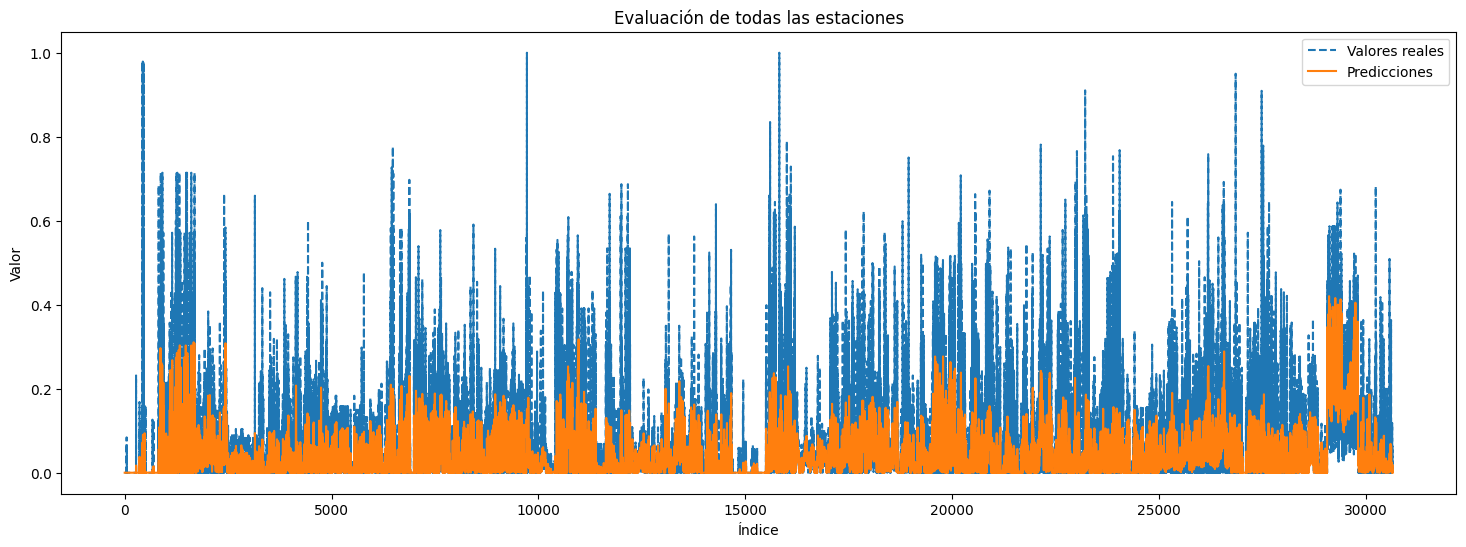

In [178]:
y_pred = best_model_dnn.predict(X_test)

# Graficar y_test vs y_pred
plt.figure(figsize=(18, 6))

# Graficar datos de la serie real (y_test)
plt.plot(y_test[:], label='Valores reales', linestyle='--')

# Graficar datos de la serie predicha (y_pred)
plt.plot(y_pred[:], label='Predicciones', linestyle='-')


# Agregar título y etiquetas
plt.title('Evaluación de todas las estaciones')
plt.xlabel('Índice')
plt.ylabel('Valor')

# Agregar leyenda
plt.legend()

# Mostrar la gráfica
plt.show()